In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

Set some arguments we will use to control how training works.

In [2]:
from dataclasses import dataclass

@dataclass
class Args:
    """Class for keeping track of training parameters"""
    batch_size: int = 128
    epochs: int = 10
    log_interval: int = 300

args = Args()

Define data loaders. We'll be using the MNIST dataset of handwritten digits.

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False)

We'll start with a fully linear model. This will just be normal PCA, but estimated using SGD.

In [4]:
class PCA(nn.Module):
    def __init__(self, num_dimensions = 10, num_pixels = 784):
        super(PCA, self).__init__()
        self.num_pixels = num_pixels

        self.fc1 = nn.Linear(self.num_pixels, num_dimensions)
        self.fc2 = nn.Linear(num_dimensions, self.num_pixels)

    def encode(self, x):
        return self.fc1(x)

    def decode(self, z):
        return self.fc2(z)

    def forward(self, x):
        rep = self.encode(x.view(-1, self.num_pixels))
        return self.decode(rep)

Next, we'll define a Bottleneck Autoencoder. We'll reduce down the high-dimensional (28 x 28 pixel image) data to 10 dimensions and see how well we do.

This is a pretty rudimentary model. See if you can modify it to work even better, for example by adding in convolutions.

For example, see [this tutorial](https://bytepawn.com/building-a-pytorch-autoencoder-for-mnist-digits.html)

In [5]:
class BottleneckAE(nn.Module):
    def __init__(self, num_dimensions = 10, num_pixels = 784):
        super(BottleneckAE, self).__init__()
        self.num_pixels = num_pixels

        self.encoder = nn.Sequential(
            nn.Linear(self.num_pixels, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_dimensions)
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_dimensions, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_pixels)
        )

    def forward(self, x):
        rep = self.encoder(x.view(-1, self.num_pixels))
        return self.decoder(rep)

Now we'll define our error function: just the reconstruction error we defined in the lecture.

We'll also create functions to train and evaluate our models.

In [6]:
def reconstruction_error(recon_x, x):
    return torch.mean(torch.pow(recon_x.view(-1, 784) -x.view(-1, 784), 2))

loss_function = reconstruction_error

def train_basic(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.6f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test_basic(epoch, model, model_name):
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/' + model_name +'_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.6f}'.format(test_loss))

Define our two models and train them.

In [7]:
pca_model = PCA()
pca_opt = optim.Adam(pca_model.parameters(), lr = 3e-4)
for epoch in range(1, args.epochs + 1):
    train_basic(epoch, pca_model, pca_opt)
    test_basic(epoch, pca_model, "PytorchPCA")

bottleneck_model = BottleneckAE()
bottleneck_opt = optim.Adam(bottleneck_model.parameters(), lr = 3e-4)
for epoch in range(1, args.epochs + 1):
    train_basic(epoch, bottleneck_model, bottleneck_opt)
    test_basic(epoch, bottleneck_model, "Bottleneck")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001170
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000510
====> Epoch: 1 Average loss: 0.000691
====> Test set loss: 0.000504
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000508
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000481
====> Epoch: 2 Average loss: 0.000480
====> Test set loss: 0.000461
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000465
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000427
====> Epoch: 3 Average loss: 0.000429
====> Test set loss: 0.000405
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000385
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000354
====> Epoch: 4 Average loss: 0.000379
====> Test set loss: 0.000361
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000361
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000337
====> Epoch: 5 Average loss: 0.000347
====> Test set loss: 0.000337
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000340
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000327
====> Epoch: 6 Average loss: 0.000329
====> Test set loss: 0.000324
Train Epoch: 7 [0/6000

To give ourselves context, we can compare these models to the closed-form version of PCA estimated through Scikit learn:

In [8]:
from sklearn.decomposition import PCA
import numpy as np

big_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=int(1e7), shuffle=True)

for data, y in big_train_loader:
    break

X_train = data.view(-1, 784).numpy()
pca = PCA(n_components = 10)
pca.fit(X_train)

def pca_skl(x):
    return torch.from_numpy(pca.inverse_transform(pca.transform(x.view(-1, 784).numpy())))

And estimate the reconstruction errors on the test set.

In [9]:
print("Pytorch PCA:")
test_basic(-1, pca_model, "PyrochPCA")

print("Scikit-learn's PCA:")
test_basic(-1, pca_skl, "sklPCA")

print("Pytorch Bottleneck AE:")
test_basic(-1, bottleneck_model, "Bottleneck")

Pytorch PCA:
====> Test set loss: 0.000290
Scikit-learn's PCA:
====> Test set loss: 0.000269
Pytorch Bottleneck AE:
====> Test set loss: 0.000142


Probably unsurprising that the Bottleneck AE has the lowest reconstruction error.

Also unsurprising that Pytorch and Scikit-learn give almost identical errors. They're the same model! The difference here is just because SGD introduces a little bit more noise into this process.

# UMAP

We can also use embeddings to provide low dimensional embeddings for high-dimensional data for visualization.

Let's check out what UMAP looks like on these handwritten digits!

In [10]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=5)

embedding = reducer.fit_transform(X_train)

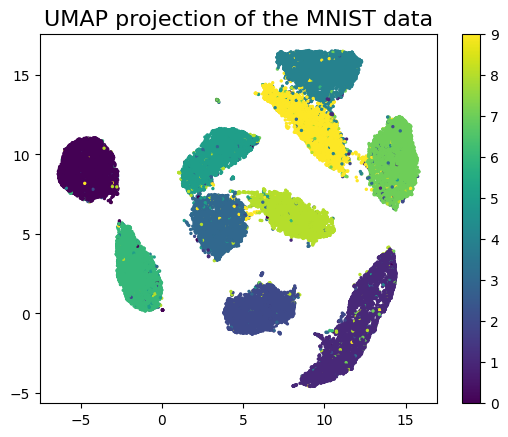

In [11]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y,
    s=2,
    cmap="viridis"
)
plt.colorbar()
plt.title('UMAP projection of the MNIST data', fontsize=16);

So each of these clusters represents a particular digit (the color is based on the actual digit label). This shows that UMAP is doing a good job of mapping out this particular form of structure!

# Variational Autoencoder

We can introduce a more complicated autoencoder which essentially does the following:
- Embeds the data in a low dimensional space
- Adds some noise to this low dimensional embedding
- Tries to reconstruct the original data from this noised embedding.

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [13]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # This is the equivalent of the reconstruction error part of the objective
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # You can think of this as a regularizer that makes sure we're actually
    # adding noise between the encoding and the decoding.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train_vae(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test_vae(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/VAE_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [14]:
for epoch in range(1, args.epochs + 1):
    train_vae(epoch)
    test_vae(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/vae_sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.648376
Train Epoch: 1 [38400/60000 (64%)]	Loss: 142.227478
====> Epoch: 1 Average loss: 164.6946
====> Test set loss: 127.0711
Train Epoch: 2 [0/60000 (0%)]	Loss: 127.386658
Train Epoch: 2 [38400/60000 (64%)]	Loss: 122.170067
====> Epoch: 2 Average loss: 121.3379
====> Test set loss: 115.7815
Train Epoch: 3 [0/60000 (0%)]	Loss: 116.731369
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.316605
====> Epoch: 3 Average loss: 114.4400
====> Test set loss: 111.6867
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.839073
Train Epoch: 4 [38400/60000 (64%)]	Loss: 111.478241
====> Epoch: 4 Average loss: 111.4155
====> Test set loss: 109.5314
Train Epoch: 5 [0/60000 (0%)]	Loss: 110.516319
Train Epoch: 5 [38400/60000 (64%)]	Loss: 105.615173
====> Epoch: 5 Average loss: 109.7248
====> Test set loss: 108.6146
Train Epoch: 6 [0/60000 (0%)]	Loss: 108.552284
Train Epoch: 6 [38400/60000 (64%)]	Loss: 109.551620
====> Epoch: 6 Average loss: 108.5704
====> Test set loss: 107.312

In [15]:
def vae_reconstruct(x):
    recon_batch, _, _ = model(x)
    return recon_batch

loss_function = reconstruction_error

test_basic(-1, vae_reconstruct, "VAE")

====> Test set loss: 0.000105


This is the lowest reconstruction error we've calculated thus far!